In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [151]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
!gpustat

instance-gpu  Sat Feb  2 10:51:28 2019
[0] Tesla P100-PCIE-16GB | 39'C,   0 % |    82 / 16280 MB | root(82M)


In [4]:
!ls

breast_cancer_1.csv  Human Activity Recognition.ipynb  UCI HAR Dataset
HAR_RAW_1.csv	     nohup.out			       UCI HAR Dataset.names


In [5]:
!ls "UCI HAR Dataset"/"train"/"Inertial Signals"

body_acc_x_train.txt  body_gyro_x_train.txt  total_acc_x_train.txt
body_acc_y_train.txt  body_gyro_y_train.txt  total_acc_y_train.txt
body_acc_z_train.txt  body_gyro_z_train.txt  total_acc_z_train.txt


In [6]:
%%sh
head -n 1 "UCI HAR Dataset"/"train"/"Inertial Signals"/body_acc_x_train.txt | wc -w

128


In [7]:
%%sh
cat "UCI HAR Dataset"/"train"/y_train.txt | wc -l
cat "UCI HAR Dataset"/"test"/y_test.txt | wc -l

7352
2947


### Preparing the dataset

In [8]:
SIGNALS = [
    'body_acc_x',
    'body_acc_y',
    'body_acc_z',
    'body_gyro_x',
    'body_gyro_y',
    'body_gyro_z',
    'total_acc_x',
    'total_acc_y',
    'total_acc_z'
]

In [9]:
def get_data(subset, part, oneHotEncoded=True):
    if part == 'features':
        all_signals = []
        for signal in SIGNALS:
            all_signals.append(np.genfromtxt(
                "UCI HAR Dataset/{}/Inertial Signals/{}_{}.txt".format(subset, signal, subset)))
        return np.transpose(all_signals, (1, 2, 0))
    elif part == 'labels':
        y = np.genfromtxt("UCI HAR Dataset/{s}/y_{s}.txt".format(s=subset))
        if oneHotEncoded:
            return pd.get_dummies(y).values
        return y

In [10]:
%%time
X_train = get_data(subset='train', part='features')
X_test = get_data(subset='test', part='features')

CPU times: user 8.35 s, sys: 626 ms, total: 8.98 s
Wall time: 8.98 s


In [11]:
%%time
y_train = get_data(subset='train', part='labels')
y_test = get_data(subset='test', part='labels')

CPU times: user 32.2 ms, sys: 3.15 ms, total: 35.3 ms
Wall time: 33.2 ms


In [12]:
X_train.shape

(7352, 128, 9)

In [13]:
X_test.shape

(2947, 128, 9)

In [14]:
y_train.shape

(7352, 6)

In [15]:
y_test.shape

(2947, 6)

### Building a LSTM structure

In [16]:
X_train.shape[1:]

(128, 9)

In [17]:
from keras.layers import LSTM, Dropout, Dense
from keras.models import Sequential

Using TensorFlow backend.


In [18]:
from talos import live
import talos

In [23]:
def get_best_lstm_model(x_train, y_test, x_val, y_val, params):

    timesteps, data_point_size = X_train.shape[1:]
    n_classes = y_train.shape[1]

    model = Sequential()
    
    model.add(LSTM(units=params['first_neuron'], 
                   input_shape=(timesteps, data_point_size)))
    model.add(Dropout(rate=params['dropout']))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer=params['optimizer'],
                 loss=params['losses'],
                 metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=2)

    return history, model

In [24]:
y_train.shape[1]

6

In [25]:
params = {
    'optimizer': ['Adam'],
    'losses': ['binary_crossentropy'],
    'first_neuron': [16, 32, 64],
    'batch_size': [16],
    'epochs': [20],
    'dropout': [0.3, 0.5, 0.7]
}

In [148]:
get_ipython().run_line_magic('matplotlib', 'inline')

### Randomised GridSearch with one layer LSTM

In [ ]:
# The ouput of this cell has been omitted because it
# the connection from the jupyter server is broken due to
# poor internet connections.

# This code runs for almost 6 hours on my GPU (Nvidia Titan XP)
t = talos.Scan(x=X_train, y=y_train,
          x_val=X_test, y_val=y_test,
          model=get_best_lstm_model,
          params=params, search_method='random',
          shuffle=True, dataset_name='HAR_RAW',
          experiment_no='1', seed=42)

In [31]:
t.details

complete_time            02/02/19/16:10
experiment_name               HAR_RAW_1
grid_downsample                    None
random_method          uniform_mersenne
reduce_loss                       False
reduction_interval                   50
reduction_method                   None
reduction_metric                val_acc
reduction_threshold                 0.2
reduction_window                     20
x_shape                  (7352, 128, 9)
y_shape                       (7352, 6)
dtype: object

In [35]:
print('We have fit {} number of models'.format(len(t.saved_models)))

We have fit 9 number of models


In [100]:
epoch_results = t.data.drop(['losses', 'optimizer', 
             'epochs', 'batch_size', 'round_epochs'], axis=1)
epoch_results['val_loss'] = epoch_results.val_loss.astype(float, inplace=True)
epoch_results['loss'] = epoch_results.loss.astype(float, inplace=True)
epoch_results['val_acc'] = epoch_results.val_acc.astype(float, inplace=True)
epoch_results['acc'] = epoch_results.acc.astype(float, inplace=True)
epoch_results.sort_values(by='val_acc', ascending=False, inplace=True)
columns = ['Val Loss', 'Train Loss',
                        'Val Accuracy', 'Train Accuracy',
                        'LSTM cells', 'Dropout']

In [101]:
print(tabulate(epoch_results.values, 
               headers=columns, 
               tablefmt='fancy_grid'))

╒════════════╤══════════════╤════════════════╤══════════════════╤══════════════╤═══════════╕
│   Val Loss │   Train Loss │   Val Accuracy │   Train Accuracy │   LSTM cells │   Dropout │
╞════════════╪══════════════╪════════════════╪══════════════════╪══════════════╪═══════════╡
│  0.0829701 │    0.0447081 │       0.971044 │         0.982567 │           64 │       0.3 │
├────────────┼──────────────┼────────────────┼──────────────────┼──────────────┼───────────┤
│  0.0801187 │    0.0529833 │       0.96816  │         0.979529 │           64 │       0.5 │
├────────────┼──────────────┼────────────────┼──────────────────┼──────────────┼───────────┤
│  0.0936313 │    0.0711846 │       0.967255 │         0.976356 │           64 │       0.7 │
├────────────┼──────────────┼────────────────┼──────────────────┼──────────────┼───────────┤
│  0.107525  │    0.0581586 │       0.96488  │         0.978963 │           32 │       0.5 │
├────────────┼──────────────┼────────────────┼──────────────────┼─────

In [102]:
r = talos.Reporting(t)

In [115]:
r.best_params()

array([[3, '20', '64', 'binary_crossentropy', 'Adam', '16', '0.3', 0],
       [7, '20', '64', 'binary_crossentropy', 'Adam', '16', '0.5', 1],
       [0, '20', '64', 'binary_crossentropy', 'Adam', '16', '0.7', 2],
       [2, '20', '32', 'binary_crossentropy', 'Adam', '16', '0.5', 3],
       [8, '20', '32', 'binary_crossentropy', 'Adam', '16', '0.3', 4],
       [6, '20', '32', 'binary_crossentropy', 'Adam', '16', '0.7', 5],
       [5, '20', '16', 'binary_crossentropy', 'Adam', '16', '0.3', 6],
       [1, '20', '16', 'binary_crossentropy', 'Adam', '16', '0.5', 7],
       [4, '20', '16', 'binary_crossentropy', 'Adam', '16', '0.7', 8]],
      dtype=object)

In [142]:
# from keras.callbacks import Callback
# from IPython.display import clear_output

In [143]:
# Code Courtesy : https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

# class PlotLearning(Callback):
#     def on_train_begin(self, logs={}):
#         self.i = 0
#         self.x = []
#         self.losses = []
#         self.val_losses = []
#         self.acc = []
#         self.val_acc = []
#         self.fig = plt.figure()
        
#         self.logs = []

#     def on_epoch_end(self, epoch, logs={}):
        
#         self.logs.append(logs)
#         self.x.append(self.i)
#         self.losses.append(logs.get('loss'))
#         self.val_losses.append(logs.get('val_loss'))
#         self.acc.append(logs.get('acc'))
#         self.val_acc.append(logs.get('val_acc'))
#         self.i += 1
#         f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
#         clear_output(wait=True)
        
#         ax1.set_yscale('log')
#         ax1.plot(self.x, self.losses, label="loss")
#         ax1.plot(self.x, self.val_losses, label="val_loss")
#         ax1.legend()
        
#         ax2.plot(self.x, self.acc, label="accuracy")
#         ax2.plot(self.x, self.val_acc, label="validation accuracy")
#         ax2.legend()
        
#         plt.show();
        
# plot = PlotLearning()

### Randomised GridSearch with 2 layer GridSearch

In [149]:
def get_best_lstm_model_2_layer(x_train, y_test, x_val, y_val, params):

    timesteps, data_point_size = X_train.shape[1:]
    n_classes = y_train.shape[1]

    model = Sequential()
    
    model.add(LSTM(units=params['first_neuron'], 
                   input_shape=(timesteps, data_point_size),
                   return_sequences=True))
    model.add(Dropout(rate=params['dropout']))
    
    model.add(LSTM(units=params['first_neuron']))
    model.add(Dropout(rate=params['dropout']))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer=params['optimizer'],
                 loss=params['losses'],
                 metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=2)

    return history, model

In [147]:
params = {
    'optimizer': ['Adam'],
    'losses': ['binary_crossentropy'],
    'first_neuron': [64],
    'batch_size': [16],
    'epochs': [20],
    'dropout': [0.3, 0.5]
}

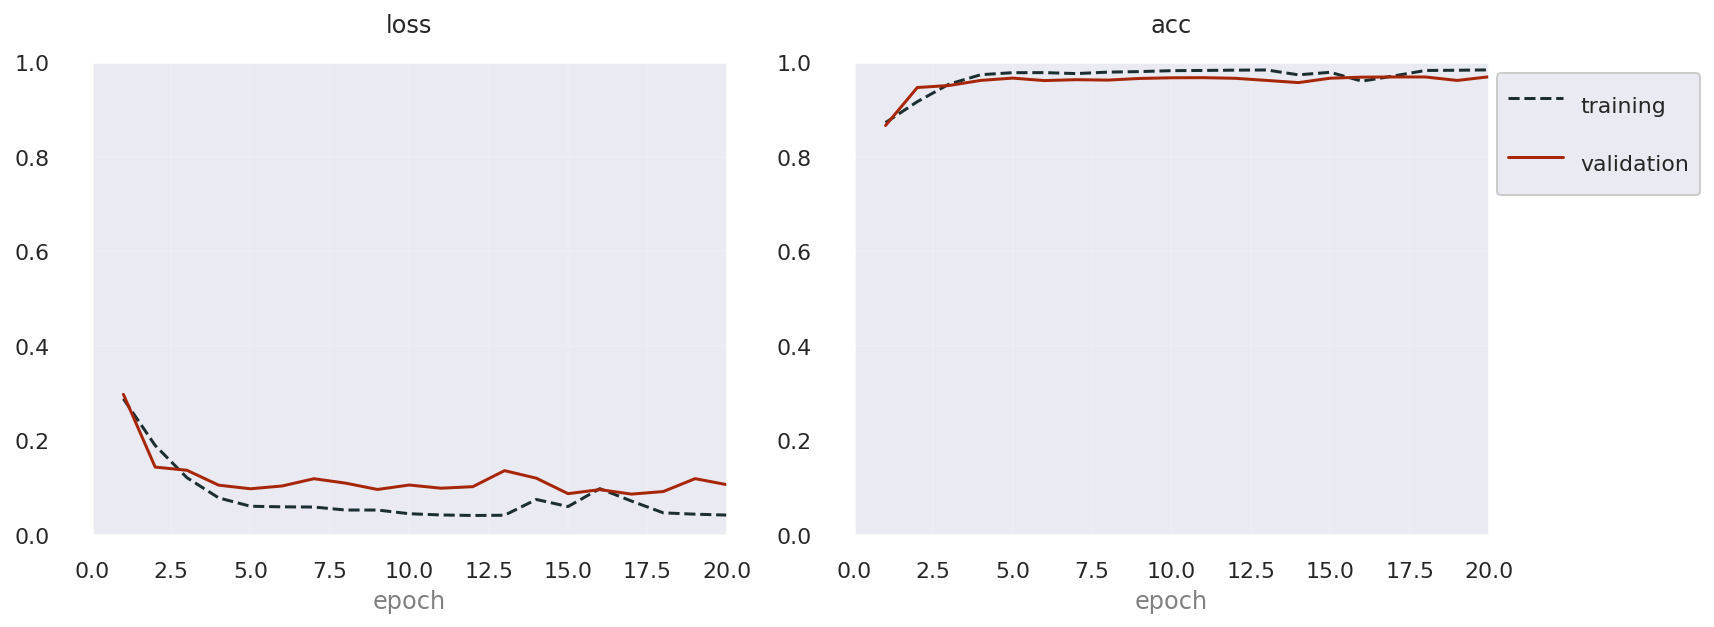


100%|██████████| 2/2 [2:21:02<00:00, 4233.94s/it]  

Scan Finished!


In [152]:
t = talos.Scan(x=X_train, y=y_train,
          x_val=X_test, y_val=y_test,
          model=get_best_lstm_model_2_layer,
          params=params, search_method='random',
          shuffle=True, dataset_name='HAR_RAW',
          experiment_no='2', seed=42)

In [153]:
t.details

complete_time            02/02/19/20:30
experiment_name               HAR_RAW_2
grid_downsample                    None
random_method          uniform_mersenne
reduce_loss                       False
reduction_interval                   50
reduction_method                   None
reduction_metric                val_acc
reduction_threshold                 0.2
reduction_window                     20
x_shape                  (7352, 128, 9)
y_shape                       (7352, 6)
dtype: object

In [154]:
print('We have fit {} number of models'.format(len(t.saved_models)))

We have fit 2 number of models


In [155]:
epoch_results = t.data.drop(['losses', 'optimizer', 
             'epochs', 'batch_size', 'round_epochs'], axis=1)
epoch_results['val_loss'] = epoch_results.val_loss.astype(float, inplace=True)
epoch_results['loss'] = epoch_results.loss.astype(float, inplace=True)
epoch_results['val_acc'] = epoch_results.val_acc.astype(float, inplace=True)
epoch_results['acc'] = epoch_results.acc.astype(float, inplace=True)
epoch_results.sort_values(by='val_acc', ascending=False, inplace=True)
columns = ['Val Loss', 'Train Loss',
                        'Val Accuracy', 'Train Accuracy',
                        'LSTM cells', 'Dropout']

In [156]:
print(tabulate(epoch_results.values, 
               headers=columns, 
               tablefmt='fancy_grid'))

╒════════════╤══════════════╤════════════════╤══════════════════╤══════════════╤═══════════╕
│   Val Loss │   Train Loss │   Val Accuracy │   Train Accuracy │   LSTM cells │   Dropout │
╞════════════╪══════════════╪════════════════╪══════════════════╪══════════════╪═══════════╡
│  0.071176  │    0.037237  │       0.971553 │         0.983678 │           64 │       0.3 │
├────────────┼──────────────┼────────────────┼──────────────────┼──────────────┼───────────┤
│  0.0857582 │    0.0404991 │       0.969743 │         0.984313 │           64 │       0.5 │
╘════════════╧══════════════╧════════════════╧══════════════════╧══════════════╧═══════════╛


In [157]:
r = talos.Reporting(t)

In [158]:
r.best_params()

array([['20', '64', 'binary_crossentropy', 'Adam', '16', '0.3', 0],
       ['20', '64', 'binary_crossentropy', 'Adam', '16', '0.5', 1]],
      dtype=object)

### Conclusion

- Talos is a wonderful library, a little buggy and difficult to get it perfect but reports many things and feels so native to GridSearchCV
- Dropouts are fitting the problem without much overfitting but this problem was computationally very expensive even on GPU
- Even 20 epochs seems more for the LSTMs. The problem is converging very soon within 15 epochs reminds me the power of LSTMs
- With LSTMs we are able to take the maximum validation acuuracy to staggering 97.2% which amazing thinking the fact that our Domain expert features are absent here. Means a person without haveing any domain expertise also can do wonder here.
- Building 2 layer LSTM structure didn't do much good but it took more time. Hence it seems better to stick to 1 layer sructure and looking at the number of training points it seems reasonable.
- One problems with talos is that it can parallelize a single model fit on GPU but can not parallelize all the model fits from GridSearch.